In [1]:
import numpy as np
import qtensor
import quimb
from cartesian_explorer import Explorer
import cartesian_explorer
from qtensor.tests import qaoa_quimb
from tqdm.auto import tqdm

/home/danlkv/.local/bin/lib/python3.8/site-packages/numba-0.52.0rc2-py3.8-linux-x86_64.egg/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PAR = True

In [4]:
cache = cartesian_explorer.caches.JobLibCache('../../caex_cache/ordering_comparison')
if PAR:
    parallel = cartesian_explorer.parallels.Ray()
    ex = Explorer(cache=cache, parallel=parallel)
else:
    ex = Explorer(cache=cache)

2021-03-06 01:51:30,143	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8266


In [5]:
@ex.provider
def graph(N, seed=10):
    return qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=3)

In [8]:
@ex.provider
def quimb_tws(graph, p, max_time=0.1, max_repeats=int(1e6)):
    args = dict(
        optimizer_time=max_time,
        dry_run=True,
        max_repeats=max_repeats,
        opt_type='hyper'
    )
    rehs = qaoa_quimb.simulate_one(graph, p, **args)
    widths = [x['W'] for x in rehs]
    return tuple(widths)
    
@ex.provider
def quimb_max_tws(quimb_tws):
    return max(quimb_tws)

In [9]:
ex.get_variable('quimb_max_tws', N=10, p=2, max_time=0.1)

8.0

In [11]:
@ex.provider
def quimb_Dsimp_tws(graph, p, max_time=0.1):
    args = dict(
        optimizer_time=max_time,
        dry_run=True,
        max_repeats=int(1e6),
        opt_type='hyper',
        simplify_sequence='D'
    )
    rehs = qaoa_quimb.simulate_one(graph, p, **args)
    widths = [x['W'] for x in rehs]
    return tuple(widths)
    
@ex.provider
def quimb_Dsimp_max_tws(quimb_Dsimp_tws):
    return max(quimb_Dsimp_tws)

In [12]:
ex.get_variable('quimb_Dsimp_max_tws', N=10, p=2, max_time=0.1)

11.0

In [10]:
@ex.provider
def qtensor_tws(graph, p, max_time=0.1, ordering_algo='rgreedy_0.02', max_repeats=int(1e6)):
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo, max_time=max_time, repeats=max_repeats)
    #comp = qtensor.QtreeQAOAComposer(graph, gamma=[0.1]*p, beta=[0.3]*p)
    sim = qtensor.QAOAQtreeSimulator(qtensor.QtreeQAOAComposer)
    gamma, beta = [0.1]*p, [0.3]*p
    tws = []
    for edge in tqdm(graph.edges()):
        circ = sim._edge_energy_circuit(graph, gamma, beta, edge)
        tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(circ)
        opt.optimize(tn)
        tws.append(opt.treewidth)
    return tuple(tws)
    
@ex.provider
def qtensor_max_tws(qtensor_tws):
    return max(qtensor_tws)

In [11]:
@ex.provider
def qtensor_mean_tws(qtensor_tws):
    return np.mean(qtensor_tws)

@ex.provider
def quimb_mean_tws(quimb_tws):
    return np.mean(quimb_tws)

In [13]:
ex.get_variable('qtensor_max_tws', N=10, p=2, max_time=0.1)

9

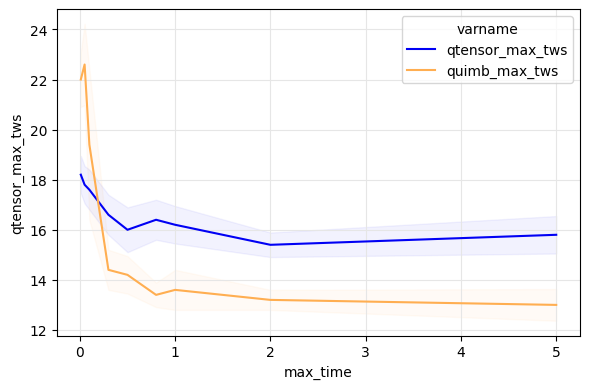

In [15]:
fig = ex.plot_variables(('qtensor_max_tws', 'quimb_max_tws'),
                        distribution_var='seed',
                        max_time=[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 5],
                        seed=range(10, 15),
                        N=[30],
                        p=[3],
                   )

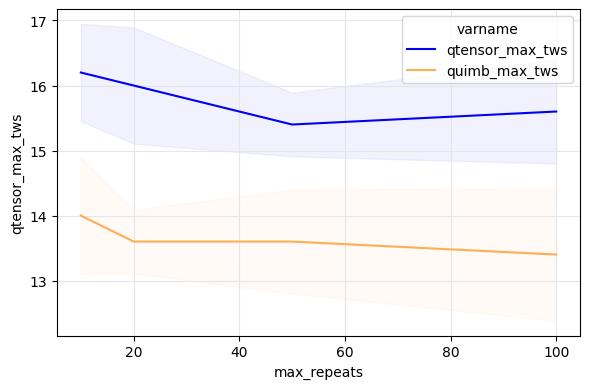

In [14]:
fig = ex.plot_variables(('qtensor_max_tws', 'quimb_max_tws'),
                        distribution_var='seed',
                        max_time=[15],
                        max_repeats=[10, 20, 50, 100],
                        seed=range(10, 15),
                        N=[30],
                        p=[3],
                   )

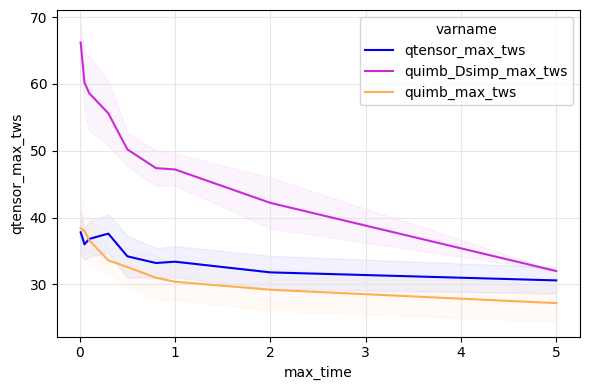

In [19]:
fig = ex.plot_variables(('qtensor_max_tws', 'quimb_Dsimp_max_tws', 'quimb_max_tws'),
                        distribution_var='seed',
                          max_time=[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 5],
                          seed=range(10, 15),
                    N=[30],
                    p=[4],
                   )

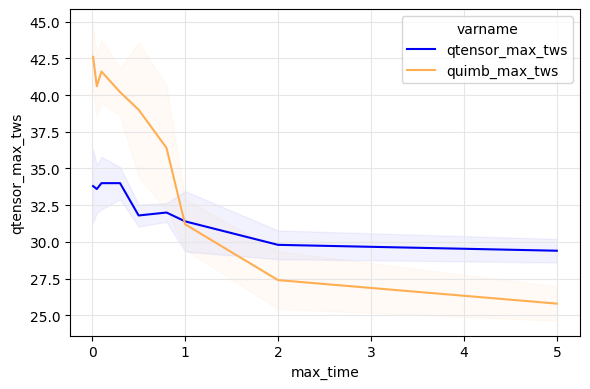

In [23]:
fig = ex.plot_variables(('qtensor_max_tws', 'quimb_max_tws'),
                        distribution_var='seed',
                        max_time=[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2, 5],
                          seed=range(10, 15),
                    N=[54],
                    p=[4],
                   )

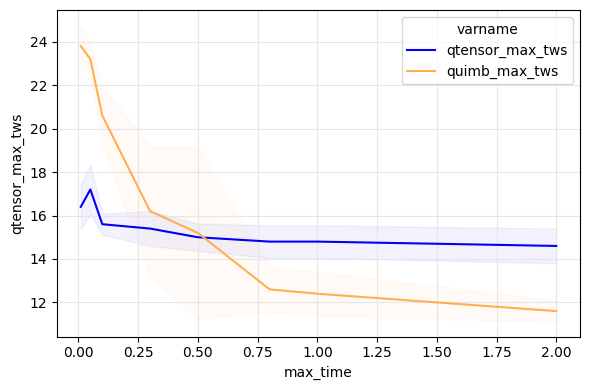

In [22]:
fig = ex.plot_variables(('qtensor_max_tws', 'quimb_Dsimp_max_tws', 'quimb_max_tws'),
                        distribution_var='seed',
                        max_time=[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 2],
                        seed=range(10, 15),
                        N=[204],
                        p=[3],
                   )